In [29]:
import functools
import operator
import string

import joblib
import textblob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline

In [2]:
# sns.set(style="whitegrid")
sns.set(style="darkgrid")

In [3]:
X = pd.read_csv('quora_challenge.csv')

In [4]:
# the vast majority of questions are short texts
X['question_text'].str.len().describe()

count    983801.000000
mean         68.881823
std          36.746332
min           5.000000
25%          44.000000
50%          59.000000
75%          83.000000
max         752.000000
Name: question_text, dtype: float64

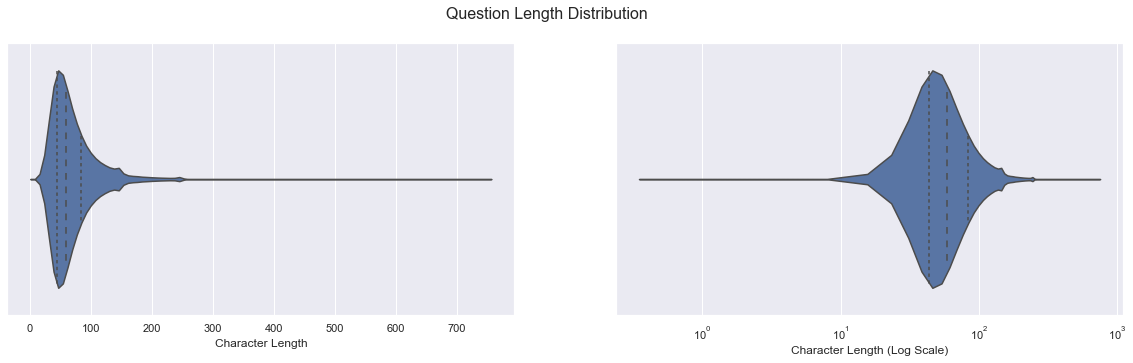

In [5]:
X['question_len'] = X['question_text'].str.len()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Question Length Distribution', fontsize=16)

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax0)
ax0.set_xlabel('Character Length')

sns.violinplot(X['question_len'], inner='quartile', orient='h', ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('Character Length (Log Scale)');

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, *, target_col='question_text', result_col='cleaned_text', pos='anvr', stop_words=None):
        self.target_col = str(target_col)
        self.result_col = str(result_col)
        self.pos = tuple(pos.lower()) if isinstance(pos, str) else tuple(pos)
        self.stop_words = () if stop_words is None else frozenset(stop_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.result_col] = (X[self.target_col].str.lower()
                                                .map(self.asciitize)
                                                .map(self.depunctuate)
                                                .map(self.lemmatize))
        return X[self.result_col].values
        
    @staticmethod
    def asciitize(text):
        return ''.join(char for char in text if char in string.printable)

    @staticmethod
    def depunctuate(text):
        return ''.join(char if char not in string.punctuation else ' ' for char in text)
    
    def lemmatize(self, text):
        tag_dict = dict(J='a', N='n', V='v', R='r')
        blob = textblob.TextBlob(text)
        
        try:
            words, tags = zip(*blob.pos_tags)
        except ValueError:
            return ''
        
        tags = (tag_dict.get(tag[0]) for tag in tags)
        lemmas = (word.lemmatize(tag) for word, tag in zip(words, tags)
                  if tag in self.pos
                  if word not in self.stop_words)
        result = ' '.join(lem for lem in lemmas if lem not in self.stop_words)
        return result if result else ' '

In [7]:
EXTRA_STOP_WORDS = frozenset("does doesn doesnt don dont im ive make quora really shouldnt youll ve weve wouldnt".split())
NOT_STOP_WORDS = frozenset("cry system".split())
CUSTOM_STOP_WORDS = ENGLISH_STOP_WORDS | EXTRA_STOP_WORDS - NOT_STOP_WORDS

In [8]:
try:
    X = pd.read_pickle('X_clean.pkl')
except Exception:
    TextPreprocessor(stop_words=CUSTOM_STOP_WORDS).fit_transform(X)
    X.to_pickle('X_clean.pkl')

In [435]:
vector_kwds = dict(
    ngram_range=(1, 2),
    stop_words=None,
    lowercase=False,
    max_df=0.9,
#     max_features=5_000,
#     max_features=10_000,
    max_features=20_000,
)

decomp_kwds = dict(
#     n_components=15,
#     n_components=20,
#     n_components=25,
#     n_components=30,
#     n_components=35,
    n_components=40,
    random_state=0,
)

topic_model_pipe = Pipeline([
#     ('textprep', TextPreprocessor()),
#     ('vectorizer', CountVectorizer(**vector_kwds)),
    ('vectorizer', TfidfVectorizer(**vector_kwds)),
    
#     ('decomposer', LSA(**decomp_kwds)),
    ('decomposer', NMF(**decomp_kwds)),
], verbose=True)

In [436]:
# X_new = topic_model_pipe.fit_transform(X)
# file_prefix = '_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()

In [437]:
X_new = topic_model_pipe.fit_transform(X['cleaned_text'])

file_prefix = ('_'.join(type(step).__name__ for step in topic_model_pipe.named_steps.values()).lower()
               + f'_topics{topic_model_pipe["decomposer"].n_components}'
               + f'_mxfeat{topic_model_pipe["vectorizer"].max_features}'
              )
file_prefix

[Pipeline] ........ (step 1 of 2) Processing vectorizer, total=  24.3s
[Pipeline] ........ (step 2 of 2) Processing decomposer, total=11.7min


'tfidfvectorizer_nmf_topics40_mxfeat20000'

In [438]:
X_new.shape

(983801, 40)

In [439]:
joblib.dump(topic_model_pipe, f'{file_prefix}__pipeline.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__pipeline.joblib']

In [440]:
joblib.dump(X_new, f'{file_prefix}__X_new.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__X_new.joblib']

In [441]:
# Get top words for each category -- does not need X
n_top = 8

feature_names = topic_model_pipe['vectorizer'].get_feature_names()
pyfunc = functools.partial(operator.getitem, feature_names)
vfunc = np.vectorize(pyfunc)

components = topic_model_pipe['decomposer'].components_
word_idxs = components.argsort(axis=1)[:, -n_top:][:, ::-1]
words = vfunc(word_idxs)

top_words_df = pd.DataFrame(words.T, columns=[f'Topic {i}' for i in range(len(words))])
top_words_df.index.name = 'Top Words'

In [442]:
top_words_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39
Top Words,,,,,,,,,,,,,,,,,,,,,
0,best,people,use,good,know,mean,year,difference,india,work,...,money,different,bad,cause,want,look,friend,change,company,woman
1,best way,people think,word,idea,best know,dream,old,main,china,start work,...,earn,type,good bad,pain,live,human,say,state,buy,men
2,place,people say,phone,good bad,fact,say,year old,main difference,pakistan,tip,...,need,different type,experience,human,just,movie,tell,united,big,man
3,best place,hate,people use,good idea,need,word,experience,similarity,buy,useful,...,online,example,bad thing,main,parent,come,best friend,united state,new,sex
4,best book,say,app,good way,need know,mean say,old girl,major,indian,tip start,...,earn money,human,bad neighborhood,dog,tell,look good,stop,number,product,indian
5,best thing,live,method,place,people know,mean dream,age,major difference,scope,useful tip,...,account,characteristic,neighborhood,problem,people want,just,help,need,software,men woman
6,website,believe,instead,good place,know fact,mean guy,old boy,similarity difference,cost,hard,...,pay,different way,movie,effect,die,future,talk,change life,service,date
7,best friend,people use,software,good book,want know,guy,year ago,word,future,experience,...,bank,form,china,main cause,want know,good look,just,possible,car,child


In [443]:
# top_words_df.to_csv('top_words.csv')

In [444]:
joblib.dump(top_words_df, f'{file_prefix}__top_words.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__top_words.joblib']

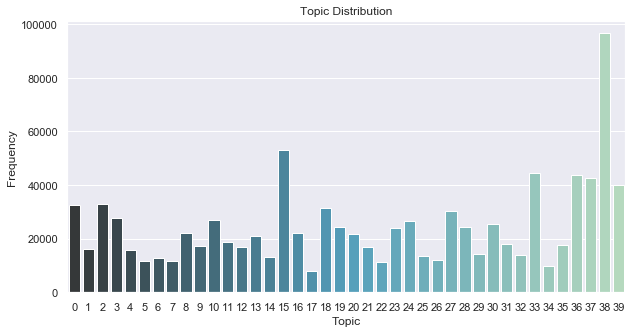

In [445]:
# Get topic count distribution
topics = np.argmax(X_new, axis=1)
x, y = np.vstack(np.unique(topics, return_counts=True))

plt.figure(figsize=(10, 5))
sns.barplot(x, y, palette='GnBu_d')
plt.title('Topic Distribution')
plt.xticks(ticks=range(len(x))
#            , labels=list('abcdefghijk')
          ) # <-- FIXME labels
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.savefig(f'{file_prefix}__topic_dist.png');

In [446]:
# Get top representative sentences
n_sents = 8
repr_idxs = np.argsort(X_new, axis=0)[-n_sents:].T
repr_sents = X['question_text'].values[repr_idxs]
# repr_sents = X['cleaned_text'].values[repr_idxs]

In [447]:
for i, sents in enumerate(repr_sents):
    print(f'Topic {i}')
    for sent in sents:
        print('\t', sent)
    print('-' * 100)

Topic 0
	 What is the best pocketknife?
	 Is Emirates the best?
	 What is the best of orthodontis?
	 What's the best typo you've ever made?
	 What's the best pornsite?
	 what are best unversities for aeronautics?
	 What is the best kombucha you've ever had?
	 What is the best find that you have ever had as an archeologist?
----------------------------------------------------------------------------------------------------
Topic 1
	 Why do people like corridas?
	 What is it called when people like each other?
	 Who are bhumihar people?
	 Why do people smirk and do you like doing it?
	 How much dalith people are there in marasthra?
	 Why do people with phenylketonuria cannot metabolize phenylalanine?
	 Who are the more fierce people, the wildlings or the dothraki?
	 Why are people afraid of psychoanalysis?
----------------------------------------------------------------------------------------------------
Topic 2
	 How do I use word2vec?
	 How could I use a moonstone?
	 What is Lipiderm 

In [448]:
joblib.dump(repr_sents, f'{file_prefix}__repr_sents.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__repr_sents.joblib']

In [449]:
# Label sentences to their best topic
X['topic'] = np.argmax(X_new, axis=1)

joblib.dump(X, f'{file_prefix}__X_clean_topic.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__X_clean_topic.joblib']

In [ ]:
# checking out likelihoods that a question should be classified as a topic
# may want a threshold for topics / allow for multiple topics if numbers are relatively close

In [454]:
np.max(X_new, axis=1)

array([0.0007464 , 0.01466068, 0.02741329, ..., 0.03592417, 0.02003667,
       0.0035982 ])

In [483]:
i = -3

In [484]:
np.sort(X_new[i])[::-1].round(4)

array([0.0359, 0.0015, 0.0007, 0.0006, 0.0006, 0.0003, 0.0003, 0.0003,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [485]:
np.argsort(X_new[i])[::-1].round(4)

array([39, 10, 17, 37, 28, 33, 13, 19, 38, 31, 16, 25, 32,  7, 18, 23,  1,
       27,  8, 29,  4,  5,  6, 11,  3,  2,  9, 36, 15, 12, 35, 14, 30, 34,
       20, 21, 22, 24, 26,  0])

In [486]:
X['question_text'].values[i]

"Is it true that the lunar cycle affects women's menstrual cycles?"

In [487]:
top_words_df.iloc[:, [39, 10, 17]]

,Topic 39,Topic 10,Topic 17
Top Words,,,
0,woman,life,love
1,men,real,fall
2,man,live,fall love
3,sex,real life,relationship
4,indian,change life,true
5,men woman,important,possible
6,date,daily life,love love
7,child,daily,people love


In [450]:
X

,question_text,question_len,cleaned_text,topic
0,How did Quebec nationalists see their province...,72,quebec nationalist province nation 1960s,27
1,"Do you have an adopted dog, how would you enco...",81,adopt dog encourage people adopt shop,1
2,Why does velocity affect time? Does velocity a...,67,velocity affect time velocity affect space geo...,12
3,How did Otto von Guericke used the Magdeburg h...,57,otto von guericke use magdeburg hemisphere,2
4,Can I convert montra helicon D to a mountain b...,77,convert montra helicon d mountain bike just ch...,37
...,...,...,...,...
983796,What info does a Facebook page receive when yo...,62,info facebook page receive page,36
983797,"If no can know God, why believe in something y...",61,know god believe know,4
983798,Is it true that the lunar cycle affects women'...,65,true lunar cycle affect woman s menstrual cycle,39
983799,What is the difference between the old currenc...,135,difference old currency note r rs new currency...,7


In [451]:
# Random selected topic sents
samples = []
for i in range(topic_model_pipe['decomposer'].n_components):
    try:
        sample = X[X['topic'] == i]['question_text'].sample(5, random_state=0)
    except ValueError:
        sample = [None]
    samples.append(sample)
    print(f'Topic {i}')
    for sent in sample:
        print('\t', sent)
    print('-' * 100)

Topic 0
	 What is the best option to get the Vedic scriptures to study?
	 Which is the best and affordable dental clinic for diastema closure in Bangalore?
	 What would be the best possible solution/compromise to improve US/Russian relations?
	 What is the best audio interface for recording vocals?
	 Have you ever been in despair? Why were you in despair?
----------------------------------------------------------------------------------------------------
Topic 1
	 What are some negative effects white people may be experiencing when it's viewed as socially unacceptable for them to be proud of their heritage and skin color?
	 Do people have the freedom to abuse their freedom?
	 Where is the law that requires people to pay income taxes?
	 Why are some people eager to highlight and display their weaknesses?
	 Does my inability to get a girlfriend because I'm diabetic have something to do with the ignorance of the people in my Alabama hick town?
---------------------------------------------

Topic 19
	 Which U.S. Armed Forces leaders rose to prominence during the Second World War? Why?
	 What are the criticisms to Brave New World?
	 Should I commit suicide today?
	 Is artificial intelligence a threat to the world?
	 Is The Hunger Games by Suzanne Collins a rip off of Battle Royale by Koushun Takami?
----------------------------------------------------------------------------------------------------
Topic 20
	 What are some of the probable predictions in Bitcoin prices after the January 16 and 17, 2018 crash? Will the (new) investors start moving away from it?
	 How can socially conscious start-up CEOs market themselves more effectively to traditional startup investors?
	 Is it rude to start guessing someone's age out loud to their face? For example, walking up to someone in a bar and saying "you must be 33 years old." I find it very rude and unnecessary.
	 How can I start to be myself?
	 What did Quora recently start filling its pages with clickbait?
----------------------

In [452]:
joblib.dump(samples, f'{file_prefix}__samples.joblib')

['tfidfvectorizer_nmf_topics40_mxfeat20000__samples.joblib']

In [362]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# EDA wordcloud from df